# Loading Data

In [3]:
import numpy as np
import os
import pickle
import joblib
import sys
import glob
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from scipy.signal import correlate
import seaborn as sea
%config InlineBackend.figure_format = 'retina'

In [4]:
def txt_to_series(input_path):
    features = []

    with open(input_path, 'r') as f:
        for line in f:
            x = line.split()
            features.append(x)

    return np.array(features).reshape((-1, 1)).astype('float64')


def array_to_window(X, window_size):
    """
    Inputs:
        X (np.array): Its shape should be (n_time_steps, n_features)
        window_size (int): the number of time steps in a window
        
    Return:
        result (np.array): Its shape should be (n_windows, window_size, n_features)
    """
    result = []
    ind = np.arange(0, X.shape[0], window_size)
    
    for start, end in zip(ind, np.r_[ind[1:], X.shape[0]]):
        if end - start < window_size:
            # Discard the last few lines
            break
        result.append(X[start:end, :])
        
    return np.array(result)

In [5]:
normality = 'normal'
source = 'ryerson_train'

input_path = '/net/adv_spectrum/data/rss/downsample_10/{}/{}/'.format(normality, source)
print(input_path)

series_list = []

for filename in sorted(glob.glob(input_path + '*.txt')):
    series = txt_to_series(filename).reshape(-1)
    series_list.append(series)

normal_series_list = series_list[:]

normal_series_array = np.hstack(normal_series_list)
th = np.quantile(normal_series_array, 0.95)

/net/adv_spectrum/data/rss/downsample_10/normal/ryerson_train/


In [6]:
autocorrs_normal = []
for i in range(len(normal_series_array) - 1):
    autocorrs_normal.append(correlate(normal_series_array[:-1][i], normal_series_array[1:][i]))
autocorrs_normal = np.array(autocorrs_normal)
th_corr = np.quantile(autocorrs_normal, 0.05)
th_corr

1569.0315313124756

In [8]:
normal_series_array

array([-40.64797656, -39.43857812, -40.07667188, ..., -40.53990625,
       -40.75473438, -40.57920313])

In [7]:
autocorrs_normal

array([1603.09839928, 1580.56695473, 1594.28632667, ..., 1667.45416848,
       1652.19311081, 1653.79464451])

In [5]:
shape_0 = normal_series_array.shape[0] // 4
normal_reshaped = normal_series_array[:shape_0 * 4].reshape(shape_0, 4)

normal_1 = normal_reshaped[:-1]
normal_2 = normal_reshaped[1:]

autocorrs_normal_frame = []
for i in range(len(normal_1)):
    autocorrs_normal_frame.append(pearsonr(normal_1[i], normal_2[i])[0])
autocorrs_normal_frame = np.array(autocorrs_normal_frame)

In [6]:
th_corr_frame = np.quantile(np.abs(autocorrs_normal_frame), 0.05)
th_corr_frame

0.047614780625445045

## 100db -10m

In [11]:
source = 'ryerson_ab_train_LOS-5M-USRP2'

In [12]:
normality = 'abnormal'
input_path = '/net/adv_spectrum/data/rss/downsample_10/{}/{}/'.format(normality, source)
print(input_path)

series_list = []

for i, filename in enumerate(sorted(glob.glob(input_path + '*.txt'))):
    series = txt_to_series(filename).reshape(-1)
    series_list.append(series)
    
abnormal_series_list = series_list[:]
detection_rates = []

for series in abnormal_series_list:
    scores = np.where(series > th, 1, 0).reshape(-1)
    result = scores.sum() / scores.size
    detection_rates.append(result)

detection_rates = np.array(detection_rates)
print('Mean:', detection_rates.mean())
print('STD:', detection_rates.std())
print()

/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-USRP2/
Mean: 0.5316282449788629
STD: 0.06351391431370686


In [25]:
corr_detection_rates = []
for array in normal_series_list:
    corrs = []
    for i in range(len(array) - 1):
        corrs.append(correlate(array[:-1][i], array[1:][i]))
    corrs = np.array(corrs)
    scores = np.where(corrs < th_corr, 1, 0).reshape(-1)
    print(scores.sum() / scores.size)
    corr_detection_rates.append(scores.sum() / scores.size)

corr_detection_rates = np.array(corr_detection_rates)
print('Mean:', corr_detection_rates.mean())
print('STD:', corr_detection_rates.std())
print()

0.038754777131224674
0.02180356308373823
0.009218182865702598
0.006900834117519028
0.004948371774436186
0.03819144373387618
0.02508113921376582
0.02689276820751154
0.18106047512050855
0.08727826749374251
0.02325670718826218
0.009704698072503569
0.003492843856721631
0.005710152164032443
0.2584548020971366
0.45899509003732086
0.008610038857201385
0.0038473110432550427
0.0030471215583850256
0.0025350002880682146
0.0017348108031981972
0.004109773194292408
0.011894016503107936
0.010402463303310223
0.007336137197288318
Mean: 0.05013043155624437
STD: 0.10219637006450118



In [14]:
dr_frame = []
for array in abnormal_series_list:
    corrs = []
    for i in range(40, len(array) - 3, 40):
        start_1, end_1 = i - 2, i + 2
        start_2, end_2 = i - 6, start_1
        seq_1 = array[start_2: end_2]
        seq_2 = array[start_1: end_1]
        corrs.append(pearsonr(seq_1, seq_2)[0])
    corrs = np.array(corrs)
    scores = np.where(np.abs(corrs) < th_corr_frame, 1, 0).reshape(-1)
    dr_frame.append(scores.sum() / scores.size)

dr_frame = np.array(dr_frame)
print('Mean:', dr_frame.mean())
print('STD:', dr_frame.std())
print()

Mean: 0.037710437710437715
STD: 0.0030111808968309585


Other

In [15]:
source = 'ryerson_ab_train_LOS-5M-USRP3'

In [16]:
normality = 'abnormal'
input_path = '/net/adv_spectrum/data/rss/downsample_10/{}/{}/'.format(normality, source)
print(input_path)

series_list = []

for i, filename in enumerate(sorted(glob.glob(input_path + '*.txt'))):
    series = txt_to_series(filename).reshape(-1)
    series_list.append(series)
    
abnormal_series_list = series_list[:]
detection_rates = []

for series in abnormal_series_list:
    scores = np.where(series > th, 1, 0).reshape(-1)
    result = scores.sum() / scores.size
    detection_rates.append(result)

detection_rates = np.array(detection_rates)
print('Mean:', detection_rates.mean())
print('STD:', detection_rates.std())
print()

corr_detection_rates = []
for array in abnormal_series_list:
    corrs = []
    for i in range(len(array) - 1):
        corrs.append(correlate(array[:-1][i], array[1:][i]))
    corrs = np.array(corrs)
    scores = np.where(corrs < th_corr, 1, 0).reshape(-1)
    corr_detection_rates.append(scores.sum() / scores.size)

corr_detection_rates = np.array(corr_detection_rates)
print('Mean:', corr_detection_rates.mean())
print('STD:', corr_detection_rates.std())
print()


dr_frame = []
for array in abnormal_series_list:
    corrs = []
    for i in range(40, len(array) - 3, 40):
        start_1, end_1 = i - 2, i + 2
        start_2, end_2 = i - 6, start_1
        seq_1 = array[start_2: end_2]
        seq_2 = array[start_1: end_1]
        corrs.append(pearsonr(seq_1, seq_2)[0])
    corrs = np.array(corrs)
    scores = np.where(np.abs(corrs) < th_corr_frame, 1, 0).reshape(-1)
    dr_frame.append(scores.sum() / scores.size)

dr_frame = np.array(dr_frame)
print('Mean:', dr_frame.mean())
print('STD:', dr_frame.std())
print()

/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-USRP3/
Mean: 0.533956746260376
STD: 0.07007923140509355

Mean: 0.6291916598915557
STD: 0.07924787596073676

Mean: 0.03763551002987623
STD: 0.002725385189643171



In [17]:
source = 'ryerson_ab_train_NLOS-5M-USRP1'

In [18]:
normality = 'abnormal'
input_path = '/net/adv_spectrum/data/rss/downsample_10/{}/{}/'.format(normality, source)
print(input_path)

series_list = []

for i, filename in enumerate(sorted(glob.glob(input_path + '*.txt'))):
    series = txt_to_series(filename).reshape(-1)
    series_list.append(series)
    
abnormal_series_list = series_list[:]
detection_rates = []

for series in abnormal_series_list:
    scores = np.where(series > th, 1, 0).reshape(-1)
    result = scores.sum() / scores.size
    detection_rates.append(result)

detection_rates = np.array(detection_rates)
print('Mean:', detection_rates.mean())
print('STD:', detection_rates.std())
print()

corr_detection_rates = []
for array in abnormal_series_list:
    corrs = []
    for i in range(len(array) - 1):
        corrs.append(correlate(array[:-1][i], array[1:][i]))
    corrs = np.array(corrs)
    scores = np.where(corrs < th_corr, 1, 0).reshape(-1)
    corr_detection_rates.append(scores.sum() / scores.size)

corr_detection_rates = np.array(corr_detection_rates)
print('Mean:', corr_detection_rates.mean())
print('STD:', corr_detection_rates.std())
print()


dr_frame = []
for array in abnormal_series_list:
    corrs = []
    for i in range(40, len(array) - 3, 40):
        start_1, end_1 = i - 2, i + 2
        start_2, end_2 = i - 6, start_1
        seq_1 = array[start_2: end_2]
        seq_2 = array[start_1: end_1]
        corrs.append(pearsonr(seq_1, seq_2)[0])
    corrs = np.array(corrs)
    scores = np.where(np.abs(corrs) < th_corr_frame, 1, 0).reshape(-1)
    dr_frame.append(scores.sum() / scores.size)

dr_frame = np.array(dr_frame)
print('Mean:', dr_frame.mean())
print('STD:', dr_frame.std())
print()

/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_NLOS-5M-USRP1/
Mean: 0.4940660008962295
STD: 0.05584818144887298

Mean: 0.54953609160377
STD: 0.08420236316431712

Mean: 0.03934699103713187
STD: 0.0031331515364110547



In [19]:
source = 'ryerson_ab_train_Dynamics-5M-USRP1'

In [20]:
normality = 'abnormal'
input_path = '/net/adv_spectrum/data/rss/downsample_10/{}/{}/'.format(normality, source)
print(input_path)

series_list = []

for i, filename in enumerate(sorted(glob.glob(input_path + '*.txt'))):
    series = txt_to_series(filename).reshape(-1)
    series_list.append(series)
    
abnormal_series_list = series_list[:]
detection_rates = []

for series in abnormal_series_list:
    scores = np.where(series > th, 1, 0).reshape(-1)
    result = scores.sum() / scores.size
    detection_rates.append(result)

detection_rates = np.array(detection_rates)
print('Mean:', detection_rates.mean())
print('STD:', detection_rates.std())
print()

corr_detection_rates = []
for array in abnormal_series_list:
    corrs = []
    for i in range(len(array) - 1):
        corrs.append(correlate(array[:-1][i], array[1:][i]))
    corrs = np.array(corrs)
    scores = np.where(corrs < th_corr, 1, 0).reshape(-1)
    corr_detection_rates.append(scores.sum() / scores.size)

corr_detection_rates = np.array(corr_detection_rates)
print('Mean:', corr_detection_rates.mean())
print('STD:', corr_detection_rates.std())
print()


dr_frame = []
for array in abnormal_series_list:
    corrs = []
    for i in range(40, len(array) - 3, 40):
        start_1, end_1 = i - 2, i + 2
        start_2, end_2 = i - 6, start_1
        seq_1 = array[start_2: end_2]
        seq_2 = array[start_1: end_1]
        corrs.append(pearsonr(seq_1, seq_2)[0])
    corrs = np.array(corrs)
    scores = np.where(np.abs(corrs) < th_corr_frame, 1, 0).reshape(-1)
    dr_frame.append(scores.sum() / scores.size)

dr_frame = np.array(dr_frame)
print('Mean:', dr_frame.mean())
print('STD:', dr_frame.std())
print()

/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_Dynamics-5M-USRP1/
Mean: 0.5438753446224236
STD: 0.06742830666345316

Mean: 0.6408996013211
STD: 0.07521687420648344

Mean: 0.03633196485309161
STD: 0.011197789758065933



In [200]:
# dr_frame = []
# for array in abnormal_series_list:
#     shape_0 = array.shape[0] // 20
#     abnormal_reshaped = array[:shape_0 * 20].reshape(shape_0, 20)

#     abnormal_1 = abnormal_reshaped[:-1]
#     abnormal_2 = abnormal_reshaped[1:]

#     corrs = []
#     for i in range(len(abnormal_1)):
#         corrs.append(pearsonr(abnormal_1[i], abnormal_2[i])[0])
#     corrs = np.array(corrs)
#     scores = np.where(corrs < th_corr_frame, 1, 0).reshape(-1)
#     dr_frame.append(scores.sum() / scores.size)

# dr_frame = np.array(dr_frame)
# print('Mean:', dr_frame.mean())
# print('STD:', dr_frame.std())

## 90db - 10m

In [202]:
source = 'ryerson_ab_train_LOS-5M-10M--90dBm-usrp1'

In [203]:
normality = 'abnormal'
input_path = '/net/adv_spectrum/data/rss/downsample_10/{}/{}/'.format(normality, source)
print(input_path)

series_list = []

for i, filename in enumerate(sorted(glob.glob(input_path + '*.txt'))):
    print(i, filename)
    series = txt_to_series(filename).reshape(-1)
    print(series.shape)
    series_list.append(series)

abnormal_series_list = series_list[:]

detection_rates = []
for series in abnormal_series_list:
    scores = np.where(series > th, 1, 0).reshape(-1)
    detection_rates.append(scores.sum() / scores.size)

detection_rates = np.array(detection_rates)
print('Mean:', detection_rates.mean())
print('STD:', detection_rates.std())

/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-10M--90dBm-usrp1/
0 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-10M--90dBm-usrp1/1518561613_1580417662_880M_5m_rss.txt
(156210,)
1 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-10M--90dBm-usrp1/1518561613_1580417712_880M_5m_rss.txt
(156210,)
2 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-10M--90dBm-usrp1/1518561613_1580417762_880M_5m_rss.txt
(156210,)
3 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-10M--90dBm-usrp1/1518561613_1580417814_880M_5m_rss.txt
(156210,)
4 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-10M--90dBm-usrp1/1518561613_1580417864_880M_5m_rss.txt
(156210,)
5 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-10M--90dBm-usrp1/1518564397_1580417614_880M_5m_rss.txt
(156210,)
6 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab

(156210,)
58 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-10M--90dBm-usrp1/1518742201_1580417814_880M_5m_rss.txt
(156210,)
59 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-10M--90dBm-usrp1/1518742201_1580417864_880M_5m_rss.txt
(156210,)
Mean: 0.7520634615794977
STD: 0.17153031738341276


In [204]:
print('Mean:', detection_rates.mean())
print('STD:', detection_rates.std())

Mean: 0.7520634615794977
STD: 0.17153031738341276


In [205]:
corr_detection_rates = []
for array in abnormal_series_list:
    corrs = []
    for i in range(len(array) - 1):
        corrs.append(correlate(array[:-1][i], array[1:][i]))
    corrs = np.array(corrs)
    scores = np.where(corrs < th_corr, 1, 0).reshape(-1)
    corr_detection_rates.append(scores.sum() / scores.size)

corr_detection_rates = np.array(corr_detection_rates)
print('Mean:', corr_detection_rates.mean())
print('STD:', corr_detection_rates.std())

Mean: 0.8298423906433049
STD: 0.18467956156855636


In [206]:
dr_frame = []
for array in abnormal_series_list:
    corrs = []
    for i in range(40, len(array) - 3, 40):
        start_1, end_1 = i - 2, i + 2
        start_2, end_2 = i - 6, start_1
        seq_1 = array[start_2: end_2]
        seq_2 = array[start_1: end_1]
        corrs.append(pearsonr(seq_1, seq_2)[0])
    corrs = np.array(corrs)
    scores = np.where(np.abs(corrs) < th_corr_frame, 1, 0).reshape(-1)
    dr_frame.append(scores.sum() / scores.size)

dr_frame = np.array(dr_frame)
print('Mean:', dr_frame.mean())
print('STD:', dr_frame.std())

Mean: 0.01942381562099872
STD: 0.007131751938006603


## 100db -idle

In [207]:
source = 'ryerson_ab_train_LOS-5M-IDLE--100dBm-usrp1'

In [208]:
normality = 'abnormal'
input_path = '/net/adv_spectrum/data/rss/downsample_10/{}/{}/'.format(normality, source)
print(input_path)

series_list = []

for i, filename in enumerate(sorted(glob.glob(input_path + '*.txt'))):
    print(i, filename)
    series = txt_to_series(filename).reshape(-1)
    print(series.shape)
    series_list.append(series)

abnormal_series_list = series_list[:]
detection_rates = []
for series in abnormal_series_list:
    scores = np.where(series > th, 1, 0).reshape(-1)
    detection_rates.append(scores.sum() / scores.size)

detection_rates = np.array(detection_rates)
print('Mean:', detection_rates.mean())
print('STD:', detection_rates.std())

/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-IDLE--100dBm-usrp1/
0 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-IDLE--100dBm-usrp1/1518564397_1580414277_880M_5m_rss.txt
(156210,)
1 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-IDLE--100dBm-usrp1/1518564397_1580414325_880M_5m_rss.txt
(156210,)
2 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-IDLE--100dBm-usrp1/1518564397_1580414375_880M_5m_rss.txt
(156210,)
3 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-IDLE--100dBm-usrp1/1518564397_1580414425_880M_5m_rss.txt
(156210,)
4 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-IDLE--100dBm-usrp1/1518564397_1580414475_880M_5m_rss.txt
(156210,)
5 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-IDLE--100dBm-usrp1/1518565194_1580414277_880M_5m_rss.txt
(156210,)
6 /net/adv_spectrum/data/rss/downsample_10/abnor

(156210,)
57 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-IDLE--100dBm-usrp1/1518810923_1580414375_880M_5m_rss.txt
(156210,)
58 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-IDLE--100dBm-usrp1/1518810923_1580414475_880M_5m_rss.txt
(156210,)
59 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-IDLE--100dBm-usrp1/1518810923_1580414526_880M_5m_rss.txt
(156210,)
Mean: 0.09259810511490942
STD: 0.09533107514867206


In [209]:
print('Mean:', detection_rates.mean())
print('STD:', detection_rates.std())

Mean: 0.09259810511490942
STD: 0.09533107514867206


In [210]:
corr_detection_rates = []
for array in abnormal_series_list:
    corrs = []
    for i in range(len(array) - 1):
        corrs.append(correlate(array[:-1][i], array[1:][i]))
    corrs = np.array(corrs)
    scores = np.where(corrs < th_corr, 1, 0).reshape(-1)
    corr_detection_rates.append(scores.sum() / scores.size)

corr_detection_rates = np.array(corr_detection_rates)
print('Mean:', corr_detection_rates.mean())
print('STD:', corr_detection_rates.std())

Mean: 0.09099304990962961
STD: 0.10696793365350374


In [211]:
dr_frame = []
for array in abnormal_series_list:
    corrs = []
    for i in range(40, len(array) - 3, 40):
        start_1, end_1 = i - 2, i + 2
        start_2, end_2 = i - 6, start_1
        seq_1 = array[start_2: end_2]
        seq_2 = array[start_1: end_1]
        corrs.append(pearsonr(seq_1, seq_2)[0])
    corrs = np.array(corrs)
    scores = np.where(np.abs(corrs) < th_corr_frame, 1, 0).reshape(-1)
    dr_frame.append(scores.sum() / scores.size)

dr_frame = np.array(dr_frame)
print('Mean:', dr_frame.mean())
print('STD:', dr_frame.std())

Mean: 0.05078104993597951
STD: 0.00349164705189781


## 100db 10m nlos

In [212]:
source = 'ryerson_ab_train_NLOS-5M-10M--100dBm-usrp1'

In [213]:
normality = 'abnormal'
input_path = '/net/adv_spectrum/data/rss/downsample_10/{}/{}/'.format(normality, source)
print(input_path)

series_list = []

for i, filename in enumerate(sorted(glob.glob(input_path + '*.txt'))):
    print(i, filename)
    series = txt_to_series(filename).reshape(-1)
    print(series.shape)
    series_list.append(series)

abnormal_series_list = series_list[:]
detection_rates = []
for series in abnormal_series_list:
    scores = np.where(series > th, 1, 0).reshape(-1)
    detection_rates.append(scores.sum() / scores.size)

detection_rates = np.array(detection_rates)

/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_NLOS-5M-10M--100dBm-usrp1/
0 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_NLOS-5M-10M--100dBm-usrp1/1518574357_1580414740_880M_5m_rss.txt
(156210,)
1 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_NLOS-5M-10M--100dBm-usrp1/1518574357_1580414790_880M_5m_rss.txt
(156210,)
2 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_NLOS-5M-10M--100dBm-usrp1/1518574357_1580414839_880M_5m_rss.txt
(156210,)
3 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_NLOS-5M-10M--100dBm-usrp1/1518574357_1580414889_880M_5m_rss.txt
(156210,)
4 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_NLOS-5M-10M--100dBm-usrp1/1518574357_1580414988_880M_5m_rss.txt
(156210,)
5 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_NLOS-5M-10M--100dBm-usrp1/1518618240_1580414790_880M_5m_rss.txt
(156210,)
6 /net/adv_spectrum/data/rss/downsample_10/abnor

(156210,)
57 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_NLOS-5M-10M--100dBm-usrp1/1518810923_1580414889_880M_5m_rss.txt
(156210,)
58 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_NLOS-5M-10M--100dBm-usrp1/1518810923_1580414938_880M_5m_rss.txt
(156210,)
59 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_NLOS-5M-10M--100dBm-usrp1/1518810923_1580414988_880M_5m_rss.txt
(156210,)


In [214]:
print('Mean:', detection_rates.mean())
print('STD:', detection_rates.std())

Mean: 0.1729473145125152
STD: 0.13230578709617954


In [215]:
corr_detection_rates = []
for array in abnormal_series_list:
    corrs = []
    for i in range(len(array) - 1):
        corrs.append(correlate(array[:-1][i], array[1:][i]))
    corrs = np.array(corrs)
    scores = np.where(corrs < th_corr, 1, 0).reshape(-1)
    corr_detection_rates.append(scores.sum() / scores.size)

corr_detection_rates = np.array(corr_detection_rates)
print('Mean:', corr_detection_rates.mean())
print('STD:', corr_detection_rates.std())

Mean: 0.1850289249232332
STD: 0.16521199666909378


In [216]:
dr_frame = []
for array in abnormal_series_list:
    corrs = []
    for i in range(40, len(array) - 3, 40):
        start_1, end_1 = i - 2, i + 2
        start_2, end_2 = i - 6, start_1
        seq_1 = array[start_2: end_2]
        seq_2 = array[start_1: end_1]
        corrs.append(pearsonr(seq_1, seq_2)[0])
    corrs = np.array(corrs)
    scores = np.where(np.abs(corrs) < th_corr_frame, 1, 0).reshape(-1)
    dr_frame.append(scores.sum() / scores.size)

dr_frame = np.array(dr_frame)
print('Mean:', dr_frame.mean())
print('STD:', dr_frame.std())

Mean: 0.05067434912505335
STD: 0.004289427807256248


## sigOver

In [157]:
source = 'ryerson_ab_train_sigOver'

In [158]:
normality = 'abnormal'
input_path = '/net/adv_spectrum/data/rss/downsample_10/{}/{}/'.format(normality, source)
print(input_path)

series_list = []

for i, filename in enumerate(sorted(glob.glob(input_path + '*.txt'))):
    print(i, filename)
    series = txt_to_series(filename).reshape(-1)
    print(series.shape)
    series_list.append(series)

abnormal_series_list = series_list[:]
detection_rates = []
for series in abnormal_series_list:
    scores = np.where(series > th, 1, 0).reshape(-1)
    detection_rates.append(scores.sum() / scores.size)

detection_rates = np.array(detection_rates)

/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_sigOver/
0 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_sigOver/1518561613_880M_5m_sigOver_rss.txt
(156214,)
1 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_sigOver/1518564397_880M_5m_sigOver_rss.txt
(156214,)
2 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_sigOver/1518565194_880M_5m_sigOver_rss.txt
(156214,)
3 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_sigOver/1518574357_880M_5m_sigOver_rss.txt
(156214,)
4 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_sigOver/1518586722_880M_5m_sigOver_rss.txt
(156214,)
5 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_sigOver/1518591120_880M_5m_sigOver_rss.txt
(156214,)
6 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_sigOver/1518614667_880M_5m_sigOver_rss.txt
(156214,)
7 /net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_s

In [159]:
print('Mean:', detection_rates.mean())
print('STD:', detection_rates.std())

Mean: 0.060684868750281805
STD: 0.06888317408950678


In [160]:
corr_detection_rates = []
for array in abnormal_series_list:
    corrs = []
    for i in range(len(array) - 1):
        corrs.append(correlate(array[:-1][i], array[1:][i]))
    corrs = np.array(corrs)
    scores = np.where(corrs < th_corr, 1, 0).reshape(-1)
    corr_detection_rates.append(scores.sum() / scores.size)

corr_detection_rates = np.array(corr_detection_rates)
print('Mean:', corr_detection_rates.mean())
print('STD:', corr_detection_rates.std())

Mean: 0.052487976979035594
STD: 0.07148638548639416


In [193]:
dr_frame = []
for array in abnormal_series_list:
    corrs = []
    for i in range(40, len(array) - 3, 40):
        start_1, end_1 = i - 2, i + 2
        start_2, end_2 = i - 6, start_1
        seq_1 = array[start_2: end_2]
        seq_2 = array[start_1: end_1]
        corrs.append(pearsonr(seq_1, seq_2)[0])
    corrs = np.array(corrs)
    scores = np.where(np.abs(corrs) < th_corr_frame, 1, 0).reshape(-1)
    dr_frame.append(scores.sum() / scores.size)

dr_frame = np.array(dr_frame)
print('Mean:', dr_frame.mean())
print('STD:', dr_frame.std())

Mean: 0.04774258197405779
STD: 0.004236775057716516


# General Trend for RSS

The following graphs shows how RSS change over time. Normal data and abnormal data are show in green and red lines. The control points happen every 40 time steps (i.e. 0.01s). The control points are only showed in the second and the third graph using blue verticle lines.

## Visualizations

### Full-Sequence RSS: 156214 time step, ~40 seconds

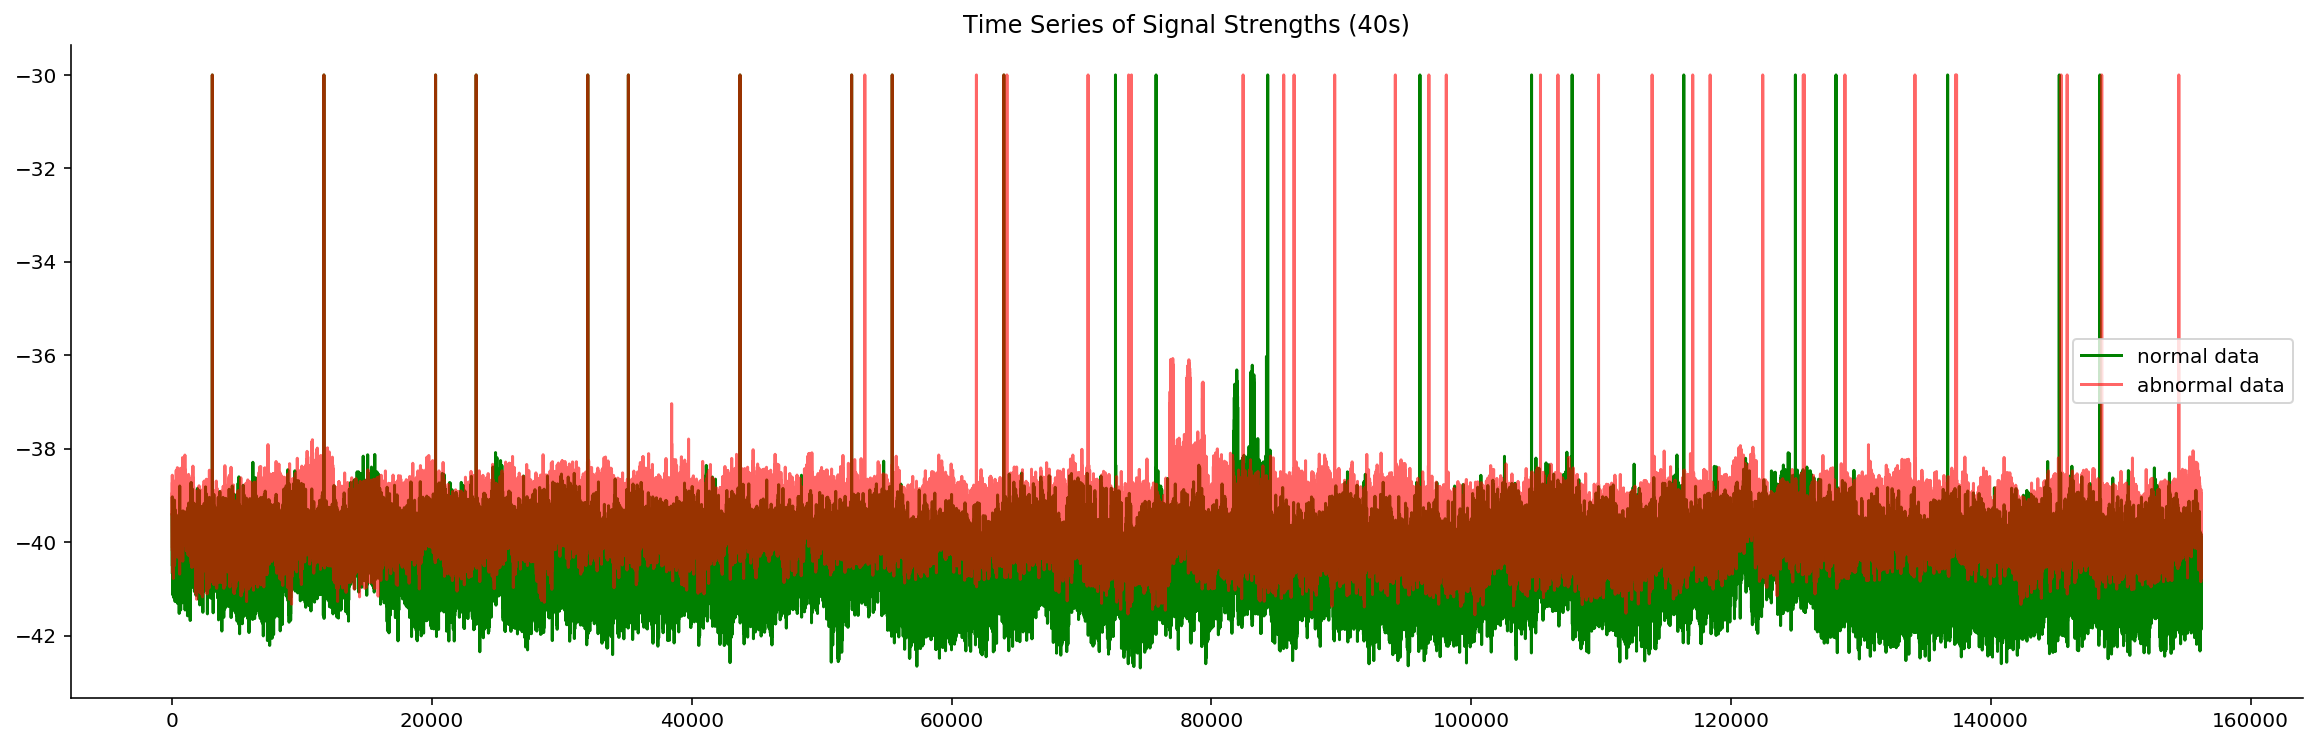

In [15]:
plt.figure(figsize=(20, 6))
plt.plot(normal_series, color='g', label='normal data')
plt.plot(abnormal_series, color='r', alpha=0.6, label='abnormal data')
plt.legend(loc='best'); plt.title('Time Series of Signal Strengths (40s)'); sea.despine()

### A Closer Look: 500 time steps, 0.128s (With Control Points Visualized)

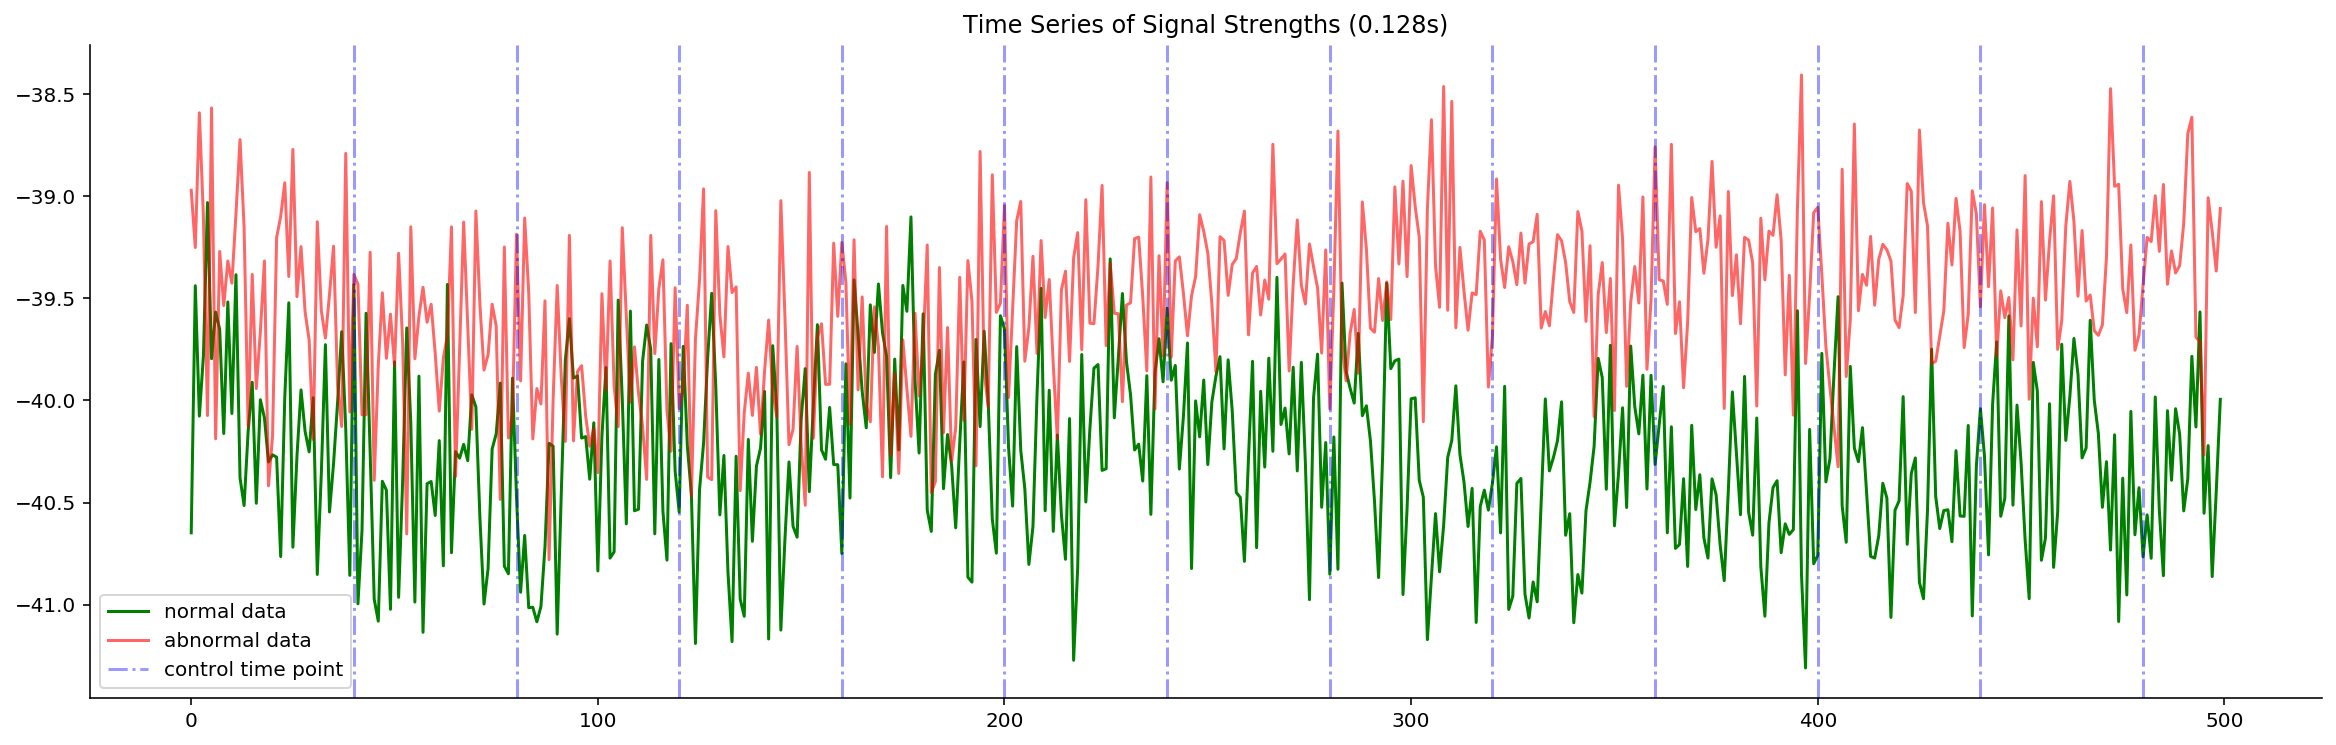

In [16]:
plt.figure(figsize=(20, 6))
plt.plot(normal_series[:500], color='g', label='normal data')
plt.plot(abnormal_series[:500], color='r', alpha=0.6, label='abnormal data')
plt.axvline(x=40, label='control time point', color='blue', alpha=0.4, ls='dashdot'); 
for i in range(80, 500, 40): plt.axvline(x=i, color='blue', alpha=0.4, ls='dashdot'); 
plt.legend(loc='best'); plt.title('Time Series of Signal Strengths (0.128s)'); sea.despine()

### A Closer Look: 250 time steps, 0.064s (With Control Points Visualized)

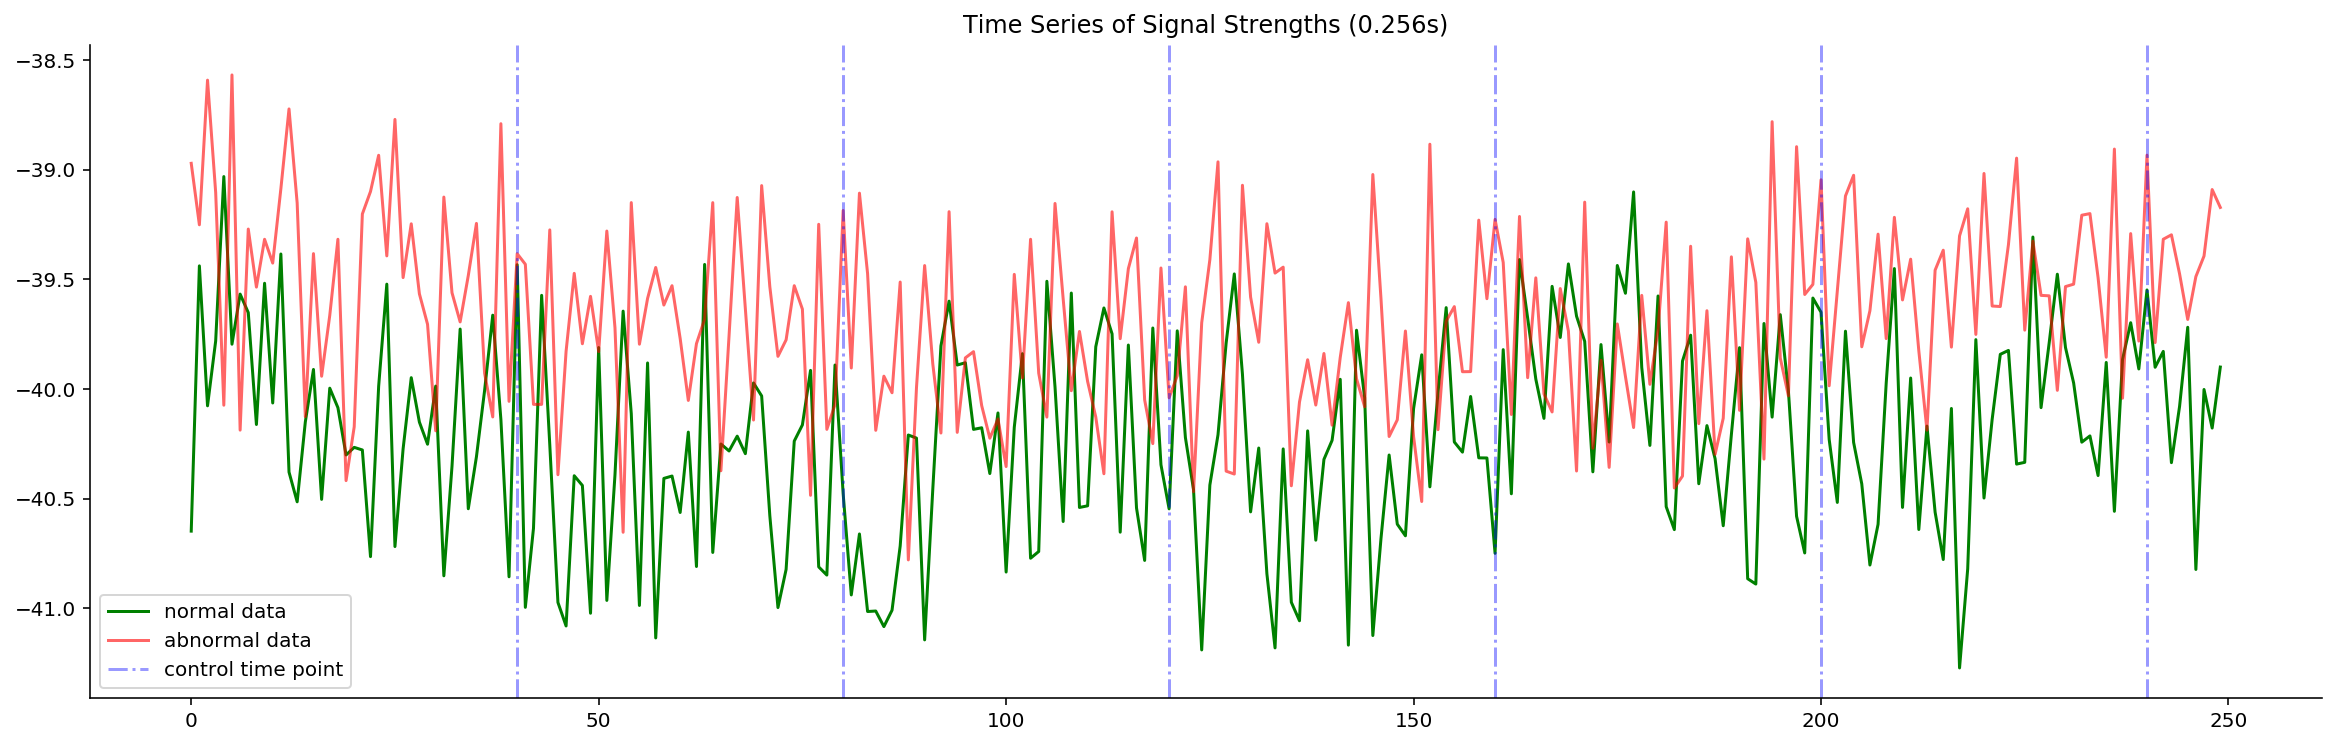

In [17]:
plt.figure(figsize=(20, 6))
plt.plot(normal_series[:250], color='g', label='normal data')
plt.plot(abnormal_series[:250], color='r', alpha=0.6, label='abnormal data')
plt.axvline(x=40, label='control time point', color='blue', alpha=0.4, ls='dashdot'); 
for i in range(80, 250, 40): plt.axvline(x=i, color='blue', alpha=0.4, ls='dashdot'); 
plt.legend(loc='best'); plt.title('Time Series of Signal Strengths (0.256s)'); sea.despine()

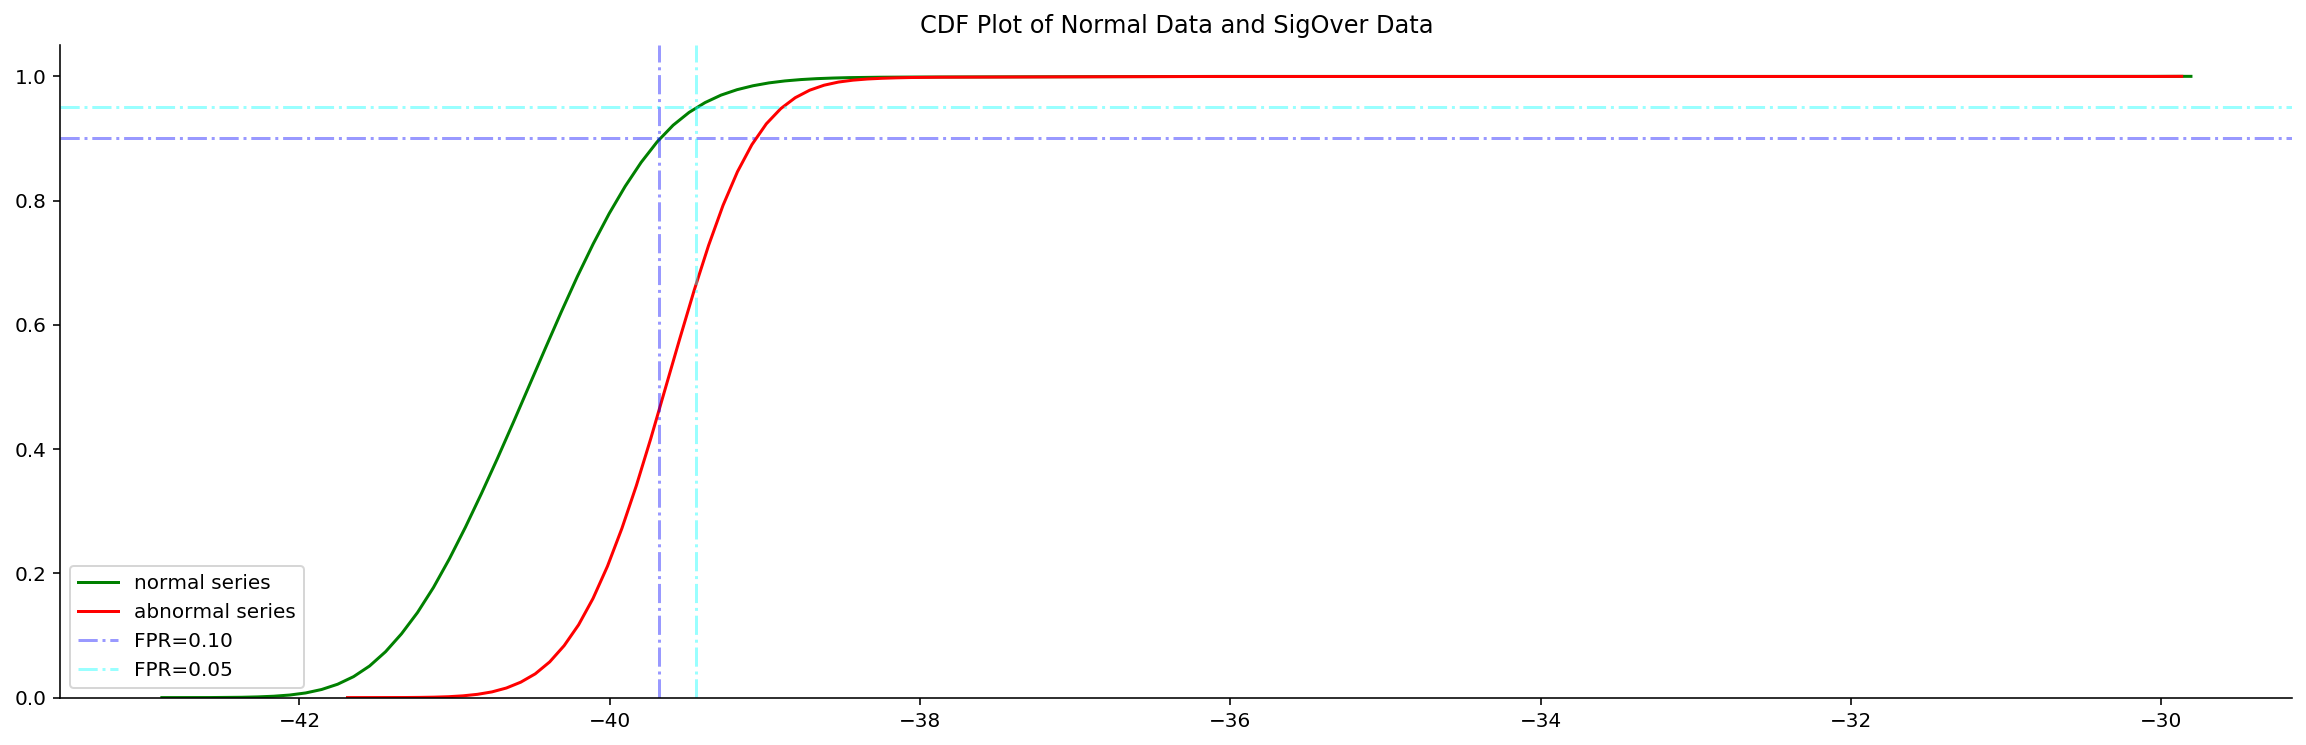

In [26]:
plt.figure(figsize=(20, 6))
sea.kdeplot(normal_series, cumulative=True, color='g', label='normal series')
sea.kdeplot(abnormal_series, cumulative=True, color='r', label='abnormal series')
plt.axhline(y=0.90, color='blue', alpha=0.4, label='FPR=0.10', ls='dashdot')
plt.axvline(x=np.quantile(normal_series, 0.90), color='blue', alpha=0.4, ls='dashdot')
plt.axhline(y=0.95, color='cyan', alpha=0.4, label='FPR=0.05', ls='dashdot')
plt.axvline(x=np.quantile(normal_series, 0.95), color='cyan', alpha=0.4, ls='dashdot')
plt.legend(loc='best'); plt.title('CDF Plot of Normal Data and SigOver Data')
sea.despine()

In [28]:
print('[Evaluate on Full fbs Sequence]\n')
th = np.quantile(normal_series, 0.90)
scores = np.where(abnormal_series > th, 1, 0).reshape(-1)
detection_rate = scores.sum() / scores.size
print('FPR: 0.10\nDetection Rate: {}\n'.format(round(detection_rate, 2)))
th = np.quantile(normal_series, 0.95)
scores = np.where(abnormal_series > th, 1, 0).reshape(-1)
detection_rate = scores.sum() / scores.size
print('FPR: 0.05\nDetection Rate: {}'.format(round(detection_rate, 2)))

[Evaluate on Full fbs Sequence]

FPR: 0.10
Detection Rate: 0.54

FPR: 0.05
Detection Rate: 0.33


From the above graphs, we can conclude the following:   
- Both normal RSS and abnomal RSS fluctuate heavily and irregularly through time;   
- Around the control points, SigOver RSS occasionally shows local maximas, but that does not show a consistent relationship with normal data's pattern.  
- Aside from the control points, SigOver RSS does not show a consistent relationship with normal data's pattern.  
- Again, most importantly, at the control points, SigOver RSS **do not necessarily show abrupt changes**. Yet we could observe abrupt changes frequently at other time steps, such that the method proposed by the paper may not work.   

# General Trend for `Autocorrelations` of RSS

> Note that the USENIX'19 paper is not clear about what correlation it uses and how it detects SigOver. So we tried two settings, one is `autocorrelation` of normal data itself and abnormal data itself; the other is `cross-correlation` of normal data with sigOver data (we will discuss this later).

For the `autocorrelation` part, I design a simple algorithm as follows:  
- Obtain the autocorrelation of the normal RSS time series;  
- Set the detection threshold as 0.10 quantile of the above autocorrelation series (i.e. fpr=0.10);  
- Obtain the autocorrelation of the SigOver RSS time series;  
- For values in the SigOver autocorrelations, predict it is abnormal if it is below the threshold.  

We'll do detection on the whole spectrum and the control channel respectively. Given Shinan's definition, the control channel refers to the time point where the SigOver is added, such that every 40 timesteps there will be a control channel. Therefore, the autocorrelation of SigOver;s controlled channels, is obtained by extract a value from the original autocorrelation sequence every 40 timesteps.

## Visualizations

### CDF Plot for Autocorrelations of Normal Data and SigOver Data

/home/ziyuye/env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


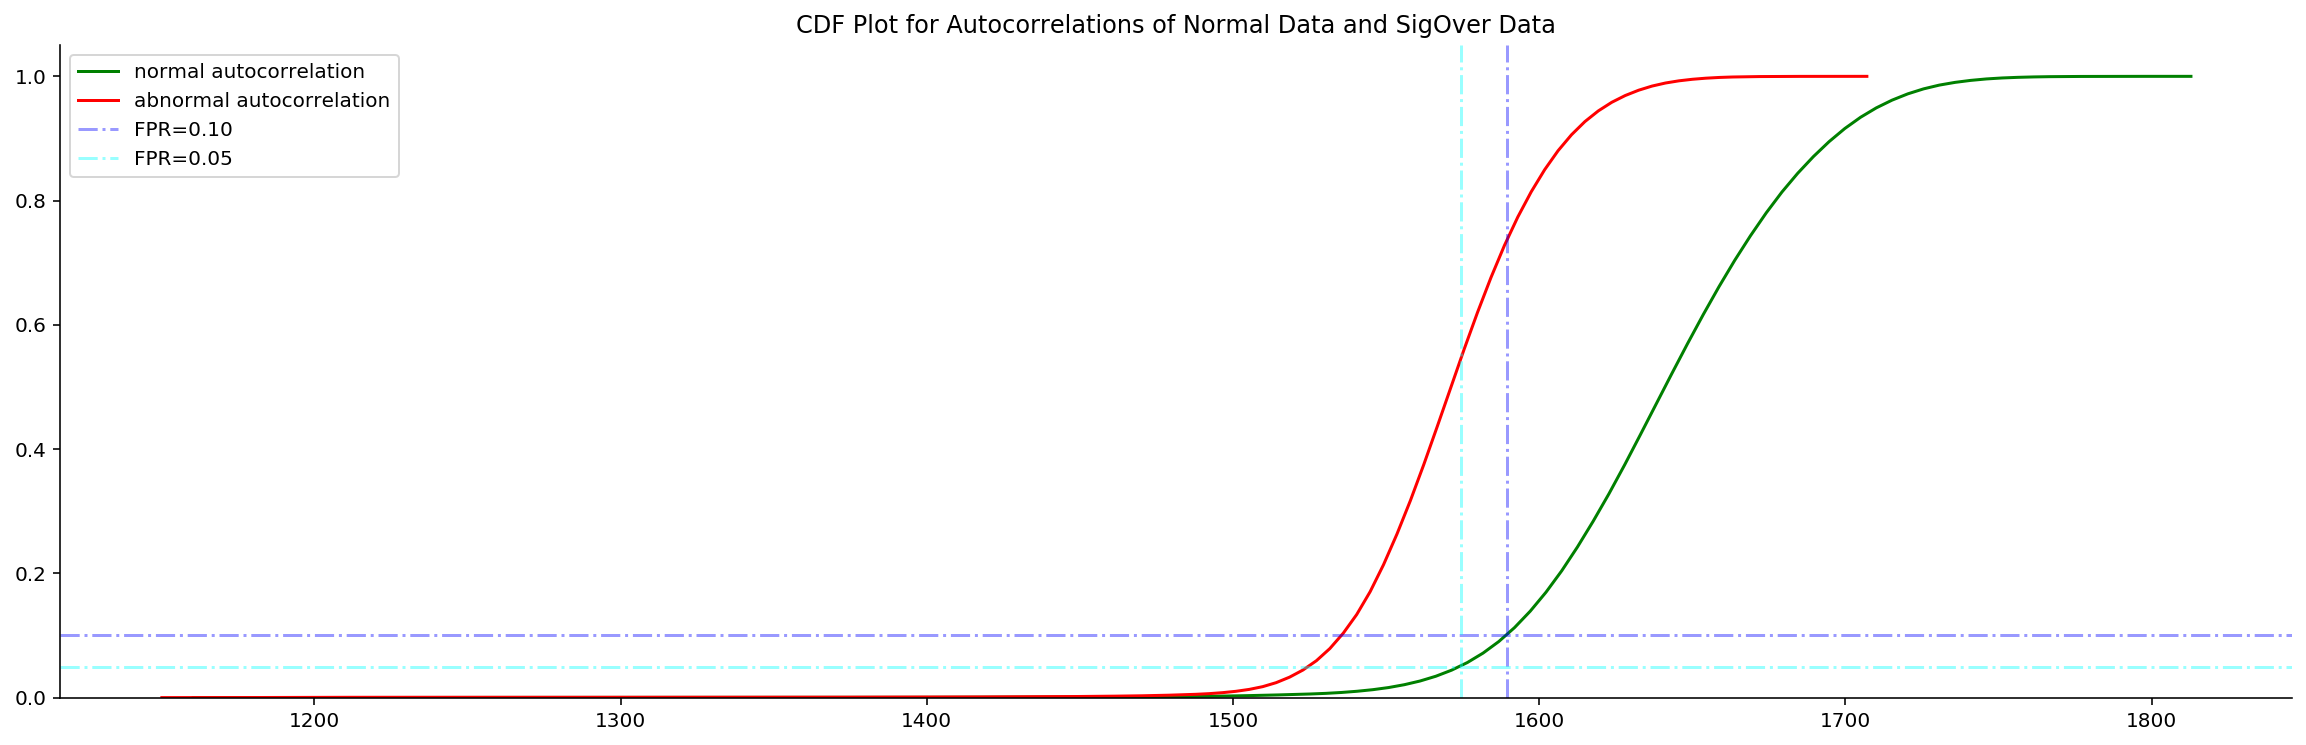

In [18]:
plt.figure(figsize=(20, 6))
sea.kdeplot(autocorrs_normal, cumulative=True, color='g', label='normal autocorrelation')
sea.kdeplot(autocorrs_abnormal, cumulative=True, color='r', label='abnormal autocorrelation')
plt.axhline(y=0.10, color='blue', alpha=0.4, label='FPR=0.10', ls='dashdot')
plt.axvline(x=np.quantile(autocorrs_normal, 0.10), color='blue', alpha=0.4, ls='dashdot')
plt.axhline(y=0.05, color='cyan', alpha=0.4, label='FPR=0.05', ls='dashdot')
plt.axvline(x=np.quantile(autocorrs_normal, 0.05), color='cyan', alpha=0.4, ls='dashdot')
plt.legend(loc='best'); plt.title('CDF Plot for Autocorrelations of Normal Data and SigOver Data')
sea.despine()

### CDF Plot for Autocorrelations of Normal Data and SigOver Data (Only Control Channel)

In [20]:
# plt.figure(figsize=(20, 6))
# sea.kdeplot(autocorrs_normal, cumulative=True, color='g', label='normal autocorrelation')
# sea.kdeplot(autocorrs_abnormal_control, cumulative=True, color='r', label='abnormal autocorrelation (control)')
# plt.axhline(y=0.10, color='blue', alpha=0.4, label='FPR=0.10', ls='dashdot')
# plt.axvline(x=np.quantile(autocorrs_normal, 0.10), color='blue', alpha=0.4, ls='dashdot'); 
# plt.axhline(y=0.05, color='cyan', alpha=0.4, label='FPR=0.05', ls='dashdot')
# plt.axvline(x=np.quantile(autocorrs_normal, 0.05), color='cyan', alpha=0.4, ls='dashdot'); 
# plt.legend(loc='best') 
# plt.title('CDF Plot for Autocorrelations of Normal Data and SigOver Data (Only Control)')
# sea.despine()

## Detection Results

### Detection Results Using Autocorrelations Full FBS Sequence

In [23]:
print('[Evaluate on Full fbs Sequence]\n')
th = np.quantile(autocorrs_normal, 0.10)
scores = np.where(autocorrs_abnormal < th, 1, 0).reshape(-1)
detection_rate = scores.sum() / scores.size
print('FPR: 0.10\nDetection Rate: {}\n'.format(round(detection_rate, 2)))
th = np.quantile(autocorrs_normal, 0.05)
scores = np.where(autocorrs_abnormal < th, 1, 0).reshape(-1)
detection_rate = scores.sum() / scores.size
print('FPR: 0.05\nDetection Rate: {}'.format(round(detection_rate, 2)))

[Evaluate on Full fbs Sequence]

FPR: 0.10
Detection Rate: 0.74

FPR: 0.05
Detection Rate: 0.55


### Detection Results Using Autocorrelations of SigOver Sequence of Control Channels

In [22]:
# print('[Evaluate on Control Channels of SigOver Sequence]\n')
# th = np.quantile(autocorrs_normal, 0.10)
# scores = np.where(autocorrs_abnormal_control < th, 1, 0).reshape(-1)
# detection_rate = scores.sum() / scores.size
# print('FPR: 0.10\nDetection Rate: {}\n'.format(round(detection_rate, 2)))
# th = np.quantile(autocorrs_normal, 0.05)
# scores = np.where(autocorrs_abnormal_control < th, 1, 0).reshape(-1)
# detection_rate = scores.sum() / scores.size
# print('FPR: 0.05\nDetection Rate: {}'.format(round(detection_rate, 2)))

# Other Methods

## Shallow Models

This method is comparable to the spectrum one, that we use a 1000-step window view to represent the data. We feed in the normal data to train a shallow model, then use the model to evaluate the SigOver data. Note that this method can only evaluate on the full data not the controlled channels.

The training process is in the appendix code part.

In [154]:
print('FPR: 0.10')
print('Detection Results: {}'.format(detection_rates))

FPR: 0.10
Detection Results: {'OCSVM': 0.09225195094760312, 'PCA': 0.06911928651059086, 'LOF': 0.2048494983277592, 'IForest': 0.07664437012263099}


LOF works best, it can detect 20% of SigOver data when fpr = 10%.

## Mean Comparison

Still, this method use the 1000-step window view and evaluate on the full abnormal data. Each data in the mean sequence is the mean of an 1000-step window of the original RSS sequence.

### Visualization of Mean Over Time

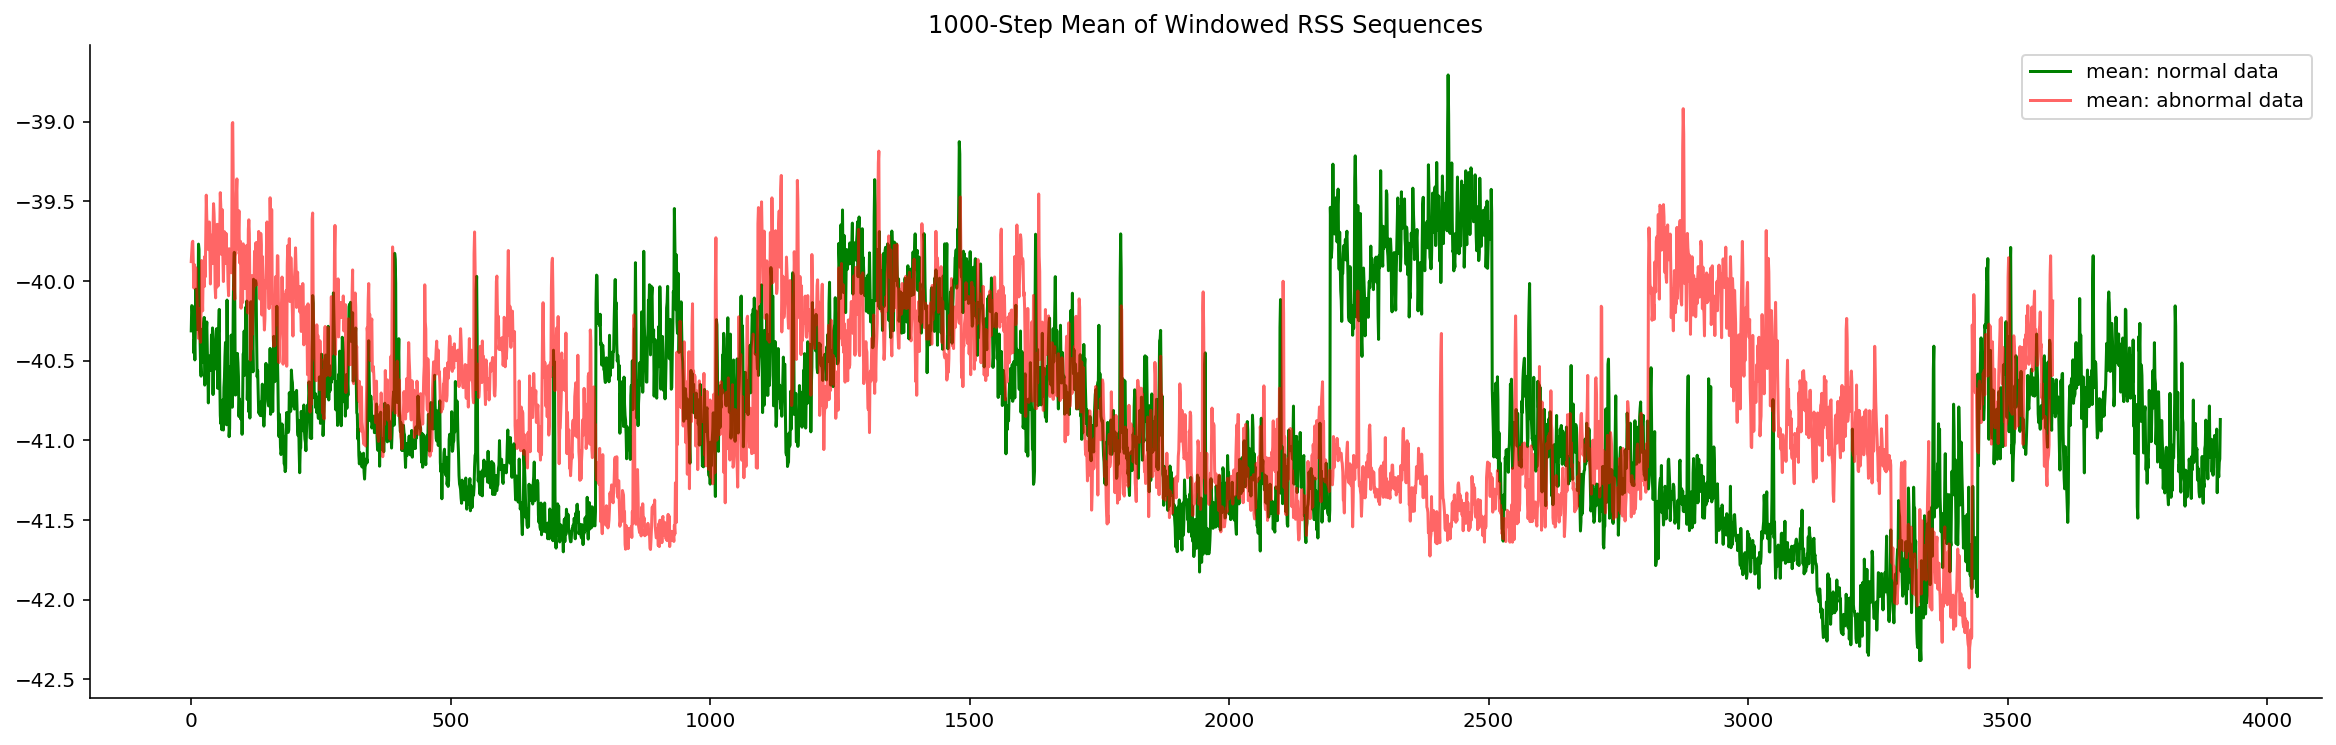

In [23]:
plt.figure(figsize=(20, 6))
plt.plot(normal_data.mean(axis=1), color='g', label='mean: normal data')
plt.plot(abnormal_data.mean(axis=1), color='r', label='mean: abnormal data', alpha=0.6)
plt.legend(loc='best'); plt.title('1000-Step Mean of Windowed RSS Sequences'); sea.despine()

### Visualization of CDF of Means

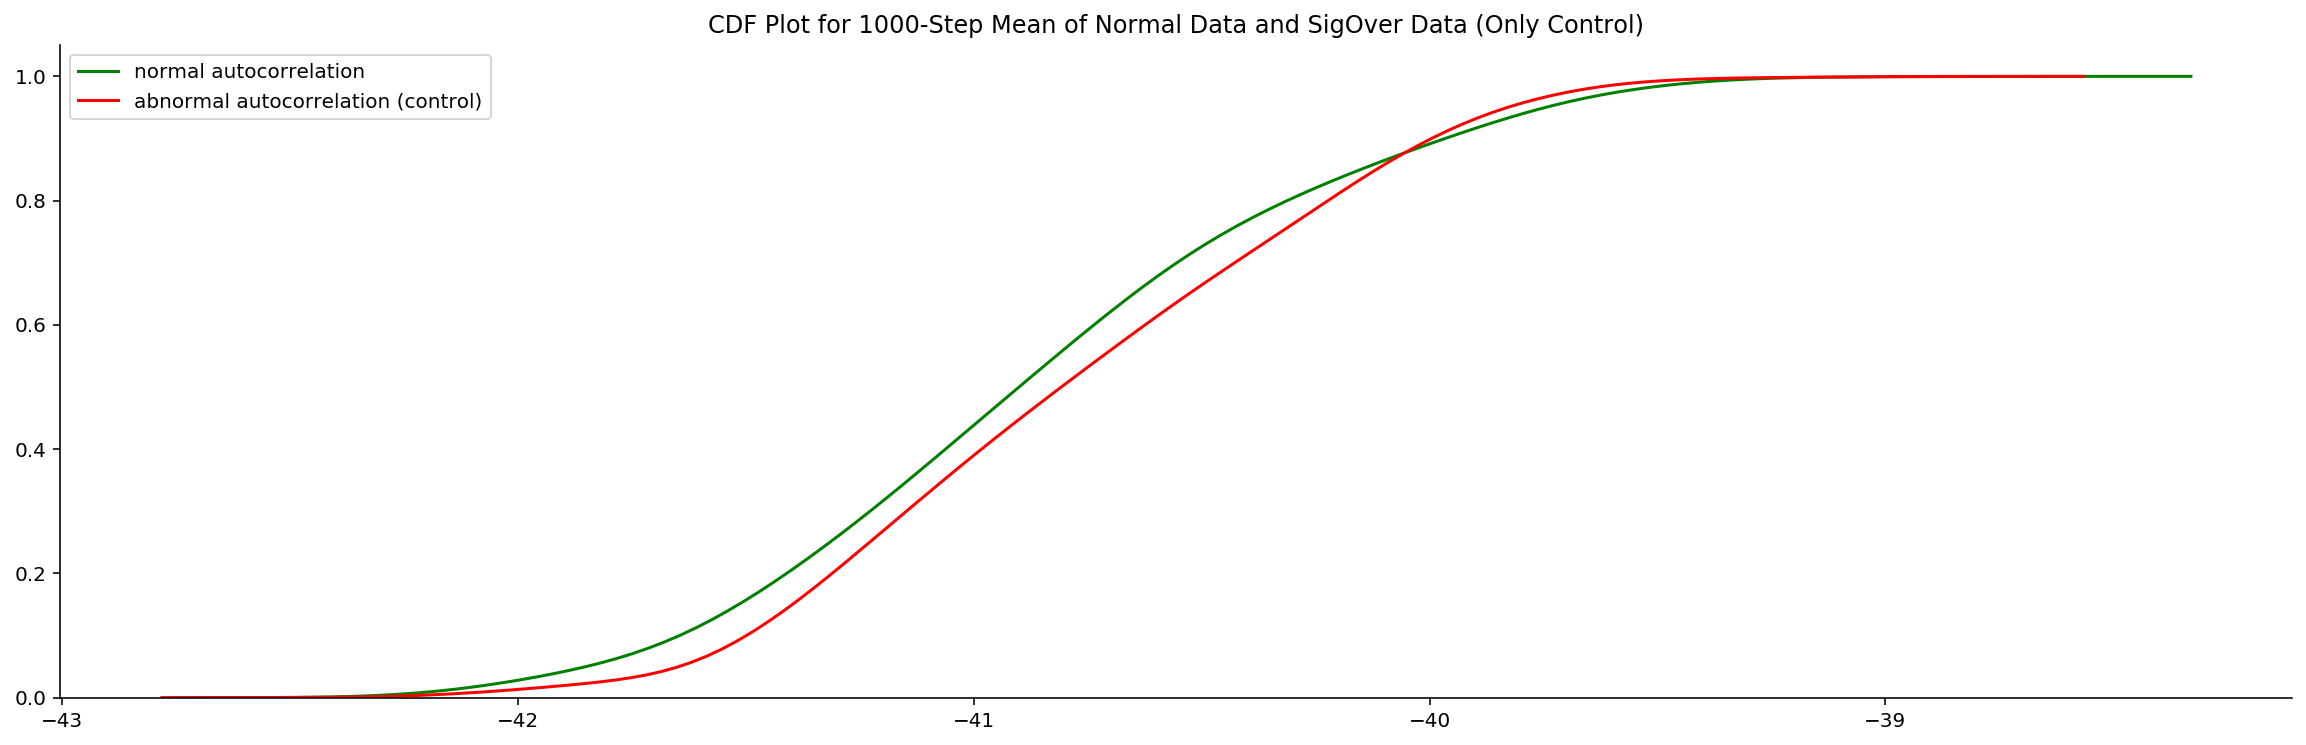

In [24]:
plt.figure(figsize=(20, 6))
sea.kdeplot(normal_data.mean(axis=1), cumulative=True, color='g', label='normal autocorrelation')
sea.kdeplot(abnormal_data.mean(axis=1), cumulative=True, color='r', label='abnormal autocorrelation (control)')
# plt.axhline(y=0.10, color='blue', alpha=0.4, label='FPR=0.10', ls='dashdot')
# plt.axvline(x=np.quantile(autocorrs_normal, 0.10), color='blue', alpha=0.4, ls='dashdot'); 
# plt.axhline(y=0.05, color='cyan', alpha=0.4, label='FPR=0.05', ls='dashdot')
# plt.axvline(x=np.quantile(autocorrs_normal, 0.05), color='cyan', alpha=0.4, ls='dashdot'); 
plt.legend(loc='best') 
plt.title('CDF Plot for 1000-Step Mean of Normal Data and SigOver Data (Only Control)')
sea.despine()

In [174]:
print('Total mean of Normal data: {}'.format(normal_data.mean()))
print('Total mean of Abormal data: {}'.format(abnormal_data.mean()))

Total mean of Normal data: -40.86115168284367
Total mean of Abormal data: -40.77767560899611


Apparently, from both the graph and the computation above, it is not reasonable to use mean to detect SigOver.

# Appendix: Codes (Safe to Skip this Part!!)

In [1]:
import numpy as np
import os
import pickle
import joblib
import sys
import glob
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from scipy.signal import correlate
import seaborn as sea
%config InlineBackend.figure_format = 'retina'

In [7]:
def txt_to_series(input_path):
    features = []

    with open(input_path, 'r') as f:
        for line in f:
            x = line.split()
            features.append(x)

    return np.array(features).reshape((-1, 1)).astype('float64')


def array_to_window(X, window_size):
    """
    Inputs:
        X (np.array): Its shape should be (n_time_steps, n_features)
        window_size (int): the number of time steps in a window
        
    Return:
        result (np.array): Its shape should be (n_windows, window_size, n_features)
    """
    result = []
    ind = np.arange(0, X.shape[0], window_size)
    
    for start, end in zip(ind, np.r_[ind[1:], X.shape[0]]):
        if end - start < window_size:
            # Discard the last few lines
            break
        result.append(X[start:end, :])
        
    return np.array(result)

In [6]:
normality = 'abnormal'
source = 'ryerson_ab_train_LOS-5M-10M--90dBm-usrp1'

input_path = '/net/adv_spectrum/data/rss/downsample_10/{}/{}/'.format(normality, source)
print(input_path)

series_list = []

# for filename in sorted(glob.glob(input_path + '*.txt')):
#     print(filename)
#     series = txt_to_series(filename)
#     print(series.shape)
#     break
#     series_list.append(series)

for i, filename in enumerate(sorted(glob.glob(input_path + '*.txt'))):
#     if i == 0:
#         continue
    print(filename)
    series = txt_to_series(filename)
    print(series.shape)
    break
    series_list.append(series)
    
abnormal_series = series.reshape(-1)

/net/adv_spectrum/data/rss/downsample_10/abnormal/ryerson_ab_train_LOS-5M-10M--90dBm-usrp/


NameError: name 'series' is not defined

In [3]:
normality = 'normal'
source = 'ryerson_train'

input_path = '/net/adv_spectrum/data/rss/downsample_10/{}/{}/'.format(normality, source)
print(input_path)

series_list = []

for filename in sorted(glob.glob(input_path + '*.txt')):
    print(filename)
    series = txt_to_series(filename)
    print(series.shape)
    break
    series_list.append(series)

normal_series = series.reshape(-1)

/net/adv_spectrum/data/rss/downsample_10/normal/ryerson_train/
/net/adv_spectrum/data/rss/downsample_10/normal/ryerson_train/1518567982_880M_5m_rss.txt
(156214, 1)


In [12]:
autocorrs_normal = []
for i in range(len(normal_series) - 1):
    autocorrs_normal.append(correlate(normal_series[:-1][i], normal_series[1:][i]))
autocorrs_normal = np.array(autocorrs_normal)

In [13]:
autocorrs_abnormal = []
for i in range(len(abnormal_series) - 1):
    autocorrs_abnormal.append(correlate(abnormal_series[:-1][i], abnormal_series[1:][i]))
autocorrs_abnormal = np.array(autocorrs_abnormal)

In [14]:
autocorrs_abnormal_control = []
for i in range(39, len(autocorrs_abnormal), 40):
    autocorrs_abnormal_control.append(autocorrs_abnormal[i])
autocorrs_abnormal_control = np.array(autocorrs_abnormal_control)

## PyOD

In [29]:
import pyod
from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.iforest import IForest

In [30]:
window_size = str(1000)
normal_name = 'ryerson_ab_train'
abnormal_name = 'ryerson_ab_train_LOS-5M-10M--100dBm-usrp1'
normal_file = '/net/adv_spectrum/array_data_rss/{}_normal_{}_rss.npy'.format(normal_name, window_size)
abnormal_file = '/net/adv_spectrum/array_data_rss/{}_abnormal_{}_rss.npy'.format(abnormal_name, window_size)
normal_data = np.load(normal_file)
abnormal_data = np.load(abnormal_file)

In [31]:
normal_data.shape

(3588, 1000)

In [32]:
detection_rates = dict()

In [33]:
clf_name = 'OCSVM'
clf = OCSVM(contamination=0.10)
clf.fit(normal_data)
abnormal_pred = clf.predict(abnormal_data)
detection_rates[clf_name] = sum(abnormal_pred) / len(abnormal_pred)

/home/ziyuye/env/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


In [34]:
clf_name = 'PCA'
clf = PCA(contamination=0.10)
clf.fit(normal_data)
abnormal_pred = clf.predict(abnormal_data)
detection_rates[clf_name] = sum(abnormal_pred) / len(abnormal_pred)

/home/ziyuye/env/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


In [35]:
clf_name = 'LOF'
clf = LOF(contamination=0.10)
clf.fit(normal_data)
abnormal_pred = clf.predict(abnormal_data)
detection_rates[clf_name] = sum(abnormal_pred) / len(abnormal_pred)

/home/ziyuye/env/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


In [36]:
clf_name = 'IForest'
clf = IForest(contamination=0.10)
clf.fit(normal_data)
abnormal_pred = clf.predict(abnormal_data)
detection_rates[clf_name] = sum(abnormal_pred) / len(abnormal_pred)

/home/ziyuye/env/lib/python3.6/site-packages/sklearn/utils/validation.py:933: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  "argument is ignored.", FutureWarning)


In [37]:
detection_rates

{'OCSVM': 0.24056408129406884,
 'PCA': 0.33278031245679524,
 'LOF': 0.05391953546246371,
 'IForest': 0.23793723213051293}